#### Import packages for estimation, simulation, and plotting

In [20]:
from scipy.stats import lognorm, poisson, norm, chi2, beta
from scipy.optimize import newton, bisect
import scipy.integrate as integrate
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.ticker import FuncFormatter

#### Define relevant functions:
- ```bid``` simulates an auction as per the rules of Example 2 in Appendix 2 of the Haile/Tamer paper.
- ```simulate``` is a wrapper around ```bid```, which generates the number of bidders and draws their valuations from a distribution. It also provides a summary of the auction.
- ```phi``` is an implicitly defined function linking the distribution of an order statistic to its parent distribution. See Arnold, Balakrishnan, and Nagaraja 1992.

In [21]:
def bid(CURRENT_PRICE, ACTIVE_BIDDERS, HISTORY, LAMBDA, INC):
    INCREMENT = max(1, CURRENT_PRICE*INC)
    if len(ACTIVE_BIDDERS) < 2:
        return HISTORY
    
    else:
        POSSIBLE_BIDDERS = ACTIVE_BIDDERS[:]
        
        if HISTORY:
            POSSIBLE_BIDDERS.remove(HISTORY[-1]["bidder"])
            
        bidder = POSSIBLE_BIDDERS[np.random.randint(len(POSSIBLE_BIDDERS))]
        
        if bidder < CURRENT_PRICE + INCREMENT:
            ACTIVE_BIDDERS.remove(bidder)
            return bid(CURRENT_PRICE, ACTIVE_BIDDERS, HISTORY, LAMBDA, INC)
        
        else:
            if np.random.rand() < LAMBDA(bidder):
                NEW_BID = np.random.uniform(CURRENT_PRICE + INCREMENT, bidder)
            else:
                NEW_BID = CURRENT_PRICE + INCREMENT
                
            HISTORY.append({
                "bidder": bidder,
                "bid": NEW_BID
            })
            return bid(NEW_BID, ACTIVE_BIDDERS, HISTORY, LAMBDA, INC)

        
def simulate(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_DISTRIBUTION, LAMBDA, INC, SILENT=1):
    N = ENTRY_DISTRIBUTION()
    BIDDERS = list(VALUE_DISTRIBUTION(size=N))
    BIDDERS = [round(bidder, 2) for bidder in BIDDERS]
    
    result = bid(STARTING_PRICE, BIDDERS, [], LAMBDA, INC)
    
    recorded_bids = {}
    for b in result:
        recorded_bids[b["bidder"]] = b["bid"]
        recorded_bids = dict(sorted(recorded_bids.items(), key=lambda item: item[1]))
    
    if not SILENT:
        print("The auction has ended.")
        print(f"There were {N} potential bidders, and {len(recorded_bids)} of them submitted bids.")
        print(f"{len(result)} rounds of bidding occured.")
        print(f"From a reserve price of {STARTING_PRICE}, the recorded bids are as follows:")

        for bidder, _bid in recorded_bids.items():
            print(f"The final bid of {bidder} is {_bid}.")

    return list(recorded_bids.values())

def phi(H, i, n):
    return bisect(lambda x: H - (\
           (math.factorial(n)/(math.factorial(n-i)*math.factorial(i-1))) \
           *integrate.quad(lambda s: s**(i-1)*(1-s)**(n-i), 0, x)[0]), -0.01, 1)

#### Define functions that calculate the upper and lower bounds of distribution of valuations, as proposed by Haile/Tamer:
- Both ```upper_bound``` and ```lower_bound``` return a callable involving a smoothing parameter, as part of the finite sample correction procedure suggested in section III.C.

In [36]:
def upper_bound(obs, _min, _max):
    EDFS = {}
    for key in obs.keys():
        for i in range(key):
            order_statistics = [l[i] for l in obs[key]]
            EDFS[f"{key}_{i+1}"] = ECDF(order_statistics)
            
    R = []

    for key, edf in EDFS.items():
        n, i = key.split("_")
        vals = []
        for j in range(_min, _max):
            try:
                vals.append(phi(edf(j/5), int(i), int(n)))
            except:
                vals.append(-1)
        R.append(vals)

    
    def func(p):
        Rmin = []
        for i in range(_max-_min):
            cdfs = [l[i] for l in R]
            tot = sum([np.exp(y*p) for y in cdfs if y >= 0])
            try:
                val = sum([y*np.exp(y*p) for y in cdfs if y >= 0])/tot
            except:
                val = -1
            Rmin.append(val)
        return Rmin
        
    return func


def lower_bound(obs, INC, _min, _max):
    EDFS = {}
    for key in obs.keys():
        EDFS[key] = ECDF([l[-1] + max(1,l[-1]*INC) for l in obs[key]])
    
    R = []

    for key, edf in EDFS.items():
        n = int(key)
        vals = []
        for j in range(_min, _max):
            try:
                vals.append(phi(edf(j/5), n-1, n))
            except:
                vals.append(-1)
        R.append(vals)
        
    
    def func(p):
        Rmax = []
        for i in range(_max-_min):
            cdfs = [l[i] for l in R]
            tot = sum([np.exp(y*p) for y in cdfs if y >= 0])
            try:
                val = sum([y*np.exp(y*p) for y in cdfs if y >= 0])/tot
            except:
                val = -1
            Rmax.append(val)
        return Rmax
        
    return func

#### Two final wrapper functions:
- Following the description of the Monte Carlo exercise carried out by Haile/Tamer, ```estimate``` simulates a given amount of auctions and returns the implied lower and upper bounds calculated using bids observed from these auctions.
- ```plot``` is the outer most wrapper, and it takes all relevant parameters:
    - ```ENTRY_DISTRIBUTION```: A callable that returns the number of potential bidders in an auction.
    - ```VALUE_RVS```: A callable of the distribution of valuations, with a ```size``` parameter.
    - ```VALUE_CDF```: A callable that is the CDF of the distribution of valuations.
    - ```LAMBDA```: A callable taking a bidder's valuation as parameter that returns a floating point value between 0 and 1 that represents the probability of a jump bid.
    - ```SAMPLE_SIZE```: The number of auctions simulated for a single upper and lower bound calculation.
    - ```INC```: Floating point value between 0 and 1. The minimum increment is the maximum between 1 and this value multiplied by the standing bid.
    - ```RANGE```: A tuple representing the range of values that should be plotted. In general this should cover most of the support of the distribution of valuations.
    - ```REPEATS```: An integer of the number of times upper and lower bounds are calculated.

In [23]:
from ipywidgets import IntProgress
from IPython.display import display


def estimate(ENTRY_DISTRIBUTION, VALUE_RVS, LAMBDA, SAMPLE_SIZE, INC, RANGE):

    STARTING_PRICE = 0
    obs = {}
    for _ in range(SAMPLE_SIZE):
        l = simulate(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, LAMBDA, INC)
        N = len(l)
        if N == 0:
            pass
        elif N in obs.keys():
            obs[N].append(list(l))
        else:
            obs[N] = [list(l)]
            
    _min, _max = [p*5 for p in RANGE]

    lower = lower_bound(obs, INC, _min, _max)
    upper = upper_bound(obs, _min, _max)
    
    return (lower, upper)


def plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, REPEATS):
    
    lowers = []
    uppers = []
    
    f = IntProgress(min=0, max=REPEATS)
    display(f) 
    
    for j in range(REPEATS):
        lower, upper = estimate(ENTRY_DISTRIBUTION, VALUE_RVS, LAMBDA, SAMPLE_SIZE, INC, RANGE)
        lowers.append(lower(SAMPLE_SIZE**0.5))
        uppers.append(upper(-SAMPLE_SIZE**0.5))
        f.value += 1
    
    
    five = [np.percentile([c for c in col if c >= 0], 5) if len([c for c in col if c >= 0])>0 else 0 for col in zip(*lowers)]
    ninetyfive = [np.percentile([c for c in col if c >= 0], 95) if len([c for c in col if c >= 0])>0 else 1 for col in zip(*uppers)]
    lower_avg = [np.mean([c for c in col if c >= 0]) for col in zip(*lowers)]
    upper_avg = [np.mean([c for c in col if c >= 0]) for col in zip(*uppers)]
    
#     print([c for c in zip(*lowers)])
    
    actual = []

    _min, _max = [p*5 for p in RANGE]
    
    for i in range(_min, _max):
        actual.append(VALUE_CDF(i/5))
        
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: (x+_min)/5))
    ax.plot(five, "-.", color="black")
    ax.plot(ninetyfive, "-.", color="purple")
    ax.plot(actual, color="blue")
    ax.plot(upper_avg, color="green")
    ax.plot(lower_avg, color="red")
    ax.set_ylim(-0.05,1.05)

IntProgress(value=0, max=20)

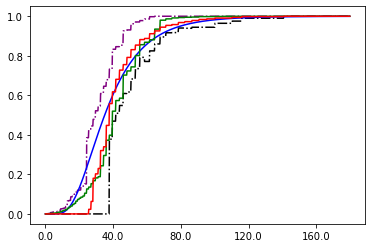

In [24]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: 0
SAMPLE_SIZE = 25
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 20)

#### Replication of Figure 4a

IntProgress(value=0, max=1)

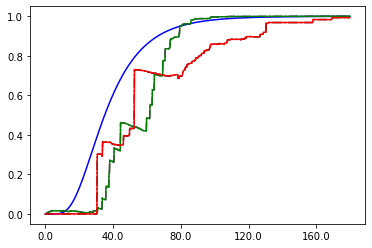

In [37]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: 0.8
SAMPLE_SIZE = 250
INC = 0.2
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 1)

#### Replication of Figure 4b

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: 0
SAMPLE_SIZE = 50
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 4c

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: 0
SAMPLE_SIZE = 100
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 4d

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: 0
SAMPLE_SIZE = 200
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

In [38]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-pastel')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.titlepad'] = 10
plt.rcParams['axes.titleweight'] = 1000
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.facecolor'] = 'white'

#### Replication of Figure 5a

IntProgress(value=0, max=500)

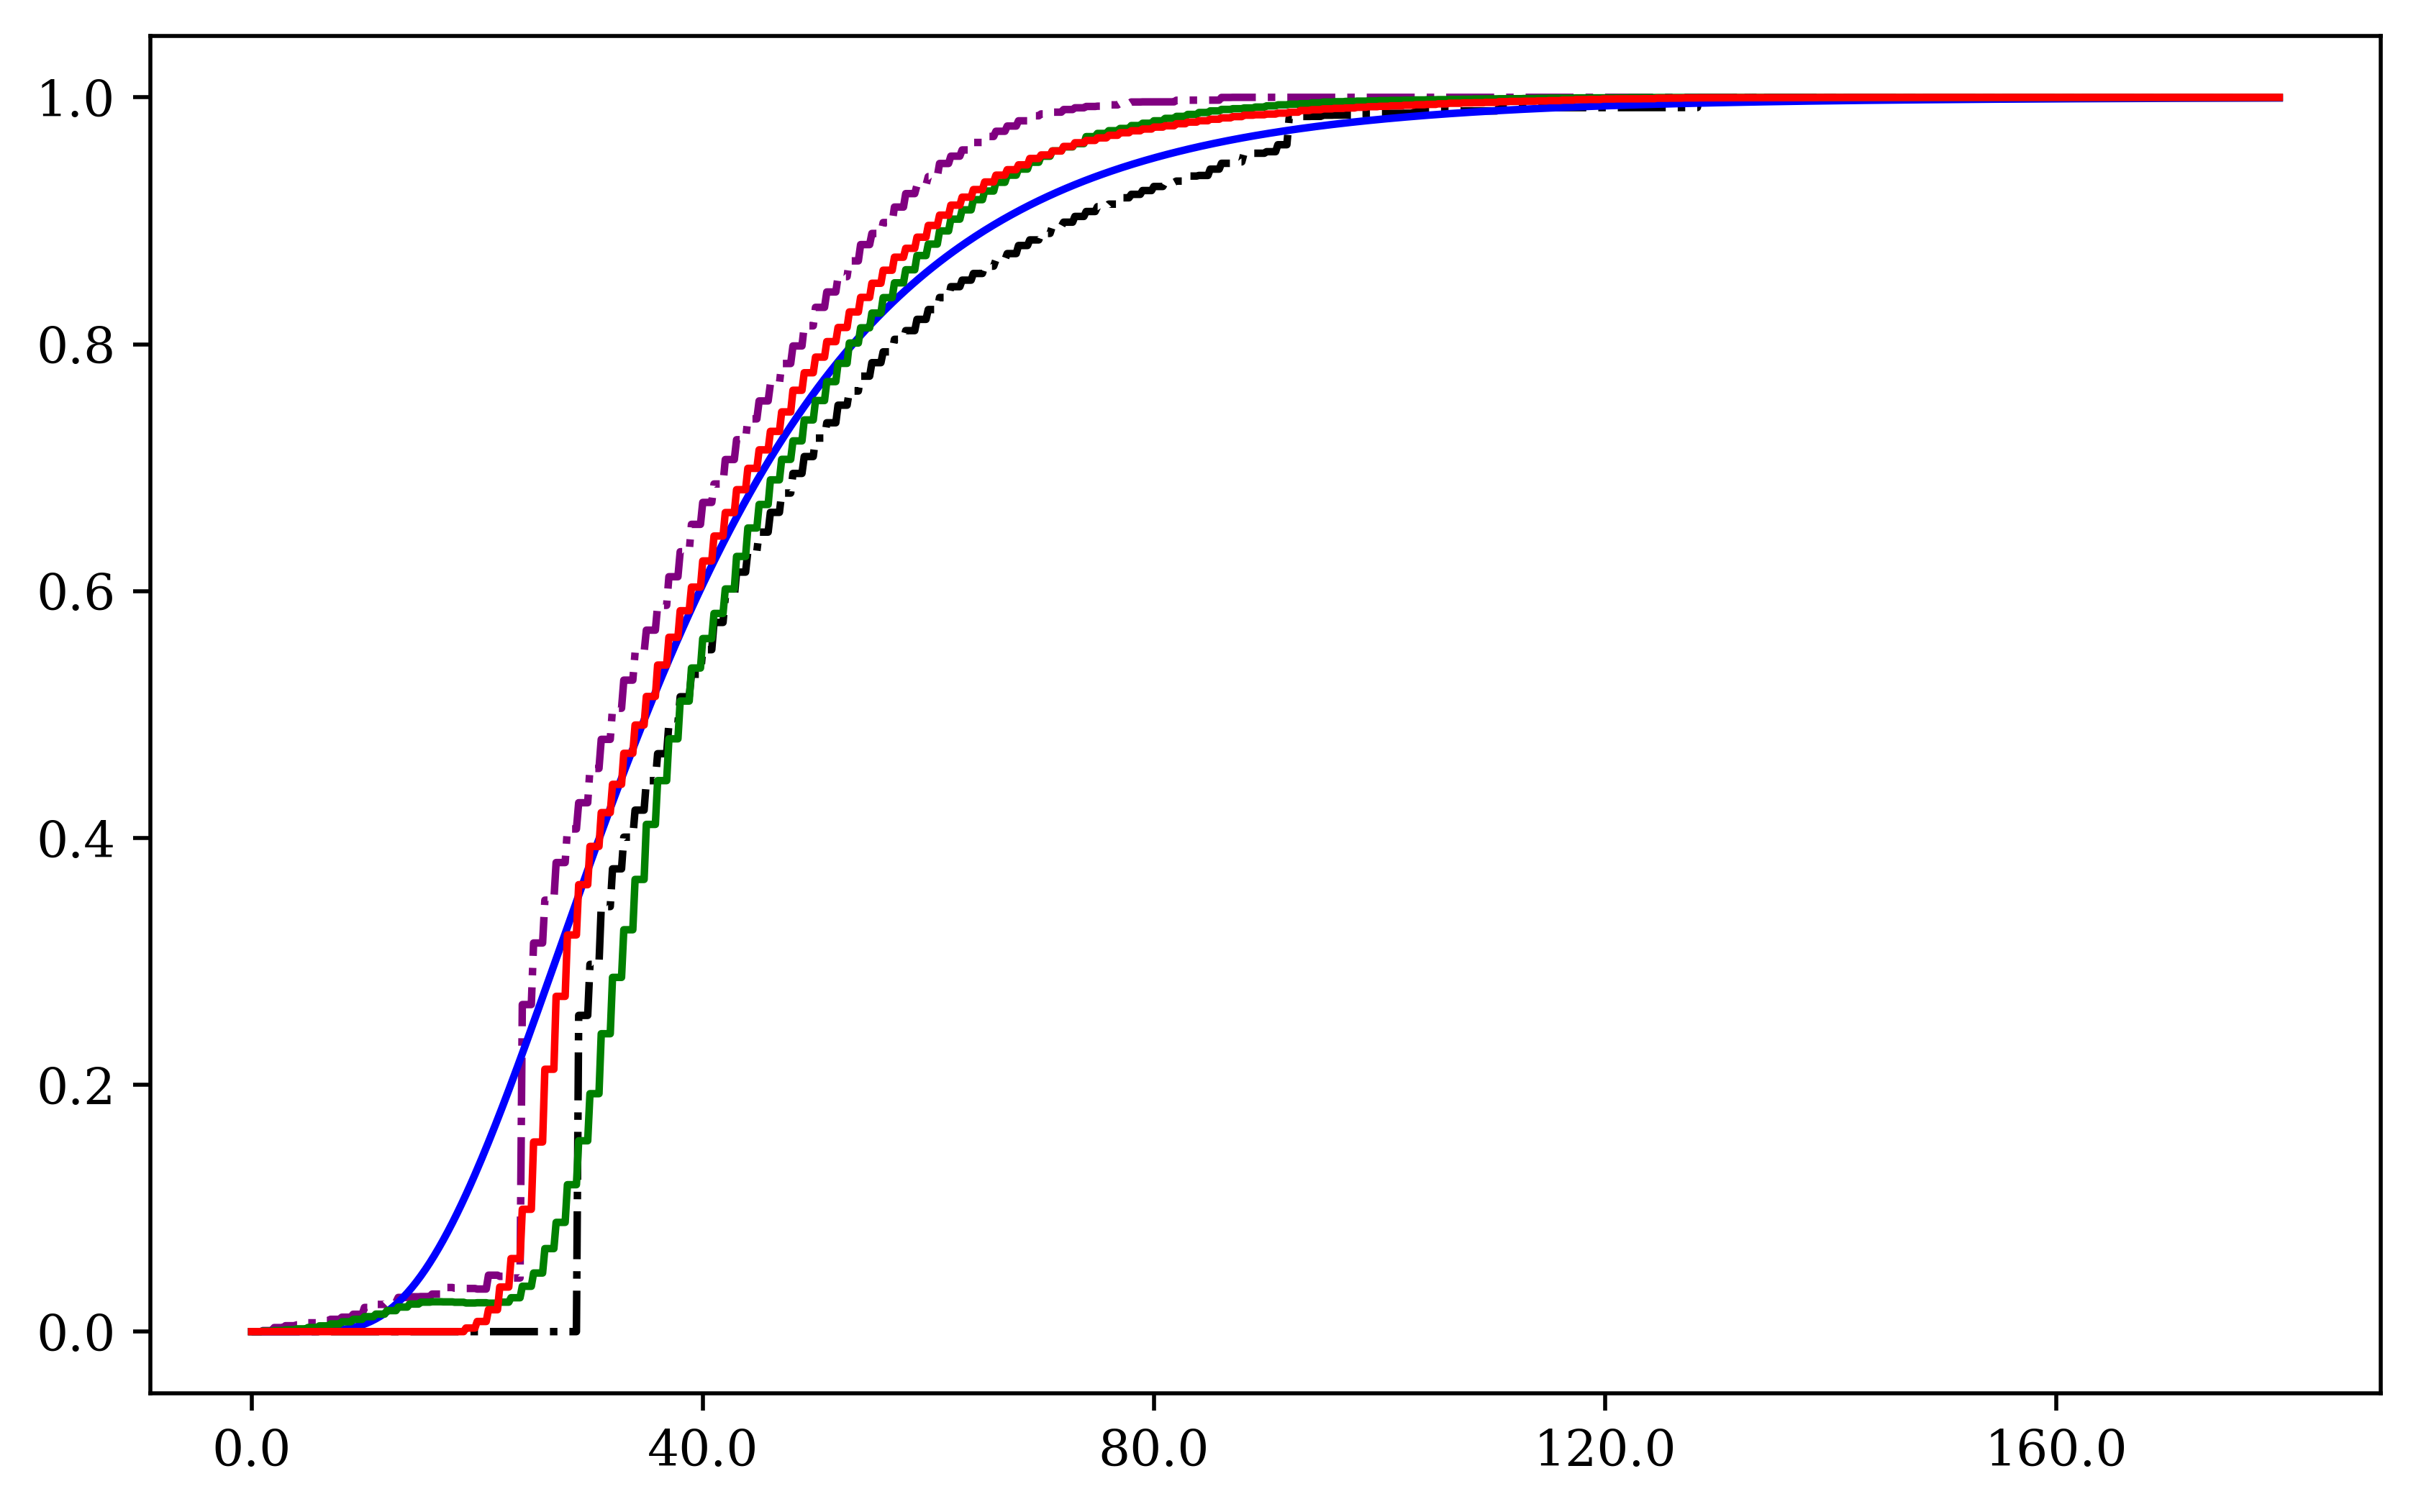

In [39]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: 0
SAMPLE_SIZE = 200
INC = 0.01
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 5b

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: 0
SAMPLE_SIZE = 200
INC = 0.1
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 5c

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: 0.25
SAMPLE_SIZE = 200
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 5d

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: lognorm.rvs(s=0.5, scale=35, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, s=0.5, scale=35)
LAMBDA = lambda v: lognorm.cdf(v, s=0.5, scale=35)**4
SAMPLE_SIZE = 200
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 6a

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: chi2.rvs(5, scale=16, size=size)
VALUE_CDF = lambda x: chi2.cdf(x, 5, scale=16)
LAMBDA = lambda v: 0
SAMPLE_SIZE = 200
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 6b

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: beta.rvs(0.5,0.5,scale=180,size=size)
VALUE_CDF = lambda x: beta.cdf(x,0.5,0.5,scale=180)
LAMBDA = lambda v: 0
SAMPLE_SIZE = 200
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 6c

In [ ]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: chi2.rvs(5, scale=16, size=size)
VALUE_CDF = lambda x: chi2.cdf(x, 5, scale=16)
LAMBDA = lambda v: 0.25
SAMPLE_SIZE = 200
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)

#### Replication of Figure 6d

IntProgress(value=0, max=1)

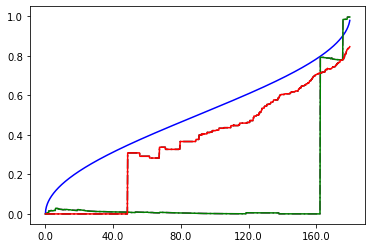

In [27]:
ENTRY_DISTRIBUTION = lambda: 6
VALUE_RVS = lambda size: beta.rvs(0.5,0.5, scale=180,size=size)
VALUE_CDF = lambda x: beta.cdf(x,0.5,0.5,scale=180)
LAMBDA = lambda v: 0.25
SAMPLE_SIZE = 200
INC = 0.05
RANGE = (0,180)

plot(ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, LAMBDA, SAMPLE_SIZE, INC, RANGE, 500)